# Projekti 3: Markovin varasto -tekniikka

# Ratkaisut

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Main qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

# Error mitigation
from qiskit_experiments.library.characterization import LocalReadoutError

In [4]:
# Noisy backend
backend = AerSimulator.from_backend(FakePerth())

# Local simulator
simulator = AerSimulator()

### Tehtävä 1

In [5]:
def zz_pump(q, c, p, system, ancilla):
    """Returns a QuantumCircuit implementing the ZZ pump channel on the system qubits
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        c (ClassicalRegister): the register to use for the measurement of the system qubits
        p (float): the efficiency for the channel, between 0 and 1
        system (list): list of indices for the system qubits
        ancilla (int): index for the ancillary qubit
    
    Returns:
        A QuantumCircuit object
    """
    zz = QuantumCircuit(q, c)
    
    theta = 2 * np.arcsin(np.sqrt(p))
    
    # Map information to ancilla
    zz.cx(q[system[0]], q[system[1]])
    zz.x(q[ancilla])
    zz.cx(q[system][1], q[ancilla])
    
    # Conditional rotation
    zz.cu(theta, 0.0, 0.0, 0.0, q[ancilla], q[system[1]])
    
    # Inverse mapping
    zz.cx(q[system[1]], q[ancilla])

    # Measurement
    zz.h(q[system[0]])
    zz.measure(q[system[0]], c[0])
    zz.measure(q[system[1]], c[1])
    
    return zz

In [6]:
def xx_pump(q, c, p, system, ancilla):
    """Returns a QuantumCircuit implementing the XX pump channel on the system qubits
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        c (ClassicalRegister): the register to use for the measurement of the system qubits
        p (float): the efficiency for the channel, between 0 and 1
        system (list): list of indices for the system qubits
        ancilla (int): index for the ancillary qubit
    
    Returns:
        A QuantumCircuit object
    """
    xx = QuantumCircuit(q, c)

    theta = 2 * np.arcsin(np.sqrt(p))
    
    # Map information to ancilla
    xx.cx(q[system[0]], q[system[1]])
    xx.h(q[system[0]])
    xx.x(q[ancilla])
    xx.cx(q[system[0]], q[ancilla])
    
    # Conditional rotation
    xx.cu(theta, 0.0, 0.0, 0.0, q[ancilla], q[system[0]])
    
    # Inverse mapping
    xx.cx(q[system[0]], q[ancilla])
    
    # Measurement
    xx.measure(q[system[0]], c[0])
    xx.measure(q[system[1]], c[1])
    
    return xx

In [7]:
def zz_xx_pump(q, c, p, system, ancillae):
    """Returns a QuantumCircuit implementing the composition channel on the system qubits
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        c (ClassicalRegister): the register to use for the measurement of the system qubits
        p (float): the efficiency for both channels, between 0 and 1
        system (list): list of indices for the system qubits
        ancillae (list): list of indices for the ancillary qubits
    
    Returns:
        A QuantumCircuit object
    """
    zx = QuantumCircuit(q, c)
    
    theta = 2 * np.arcsin(np.sqrt(p))
    
    # ZZ pump
    ## Map information to ancilla
    zx.cx(q[system[0]], q[system[1]])
    zx.x(q[ancillae[0]])
    zx.cx(q[system[1]], q[ancillae[0]])
    
    ## Conditional rotation
    zx.cu(theta, 0.0, 0.0, 0.0, q[ancillae[0]], q[system[1]])
    
    ## Inverse mapping
    zx.cx(q[system[1]], q[ancillae[0]])
    
    # XX pump
    ## Map information to ancilla
    zx.h(q[system[0]])
    zx.x(q[ancillae[1]])
    zx.cx(q[system[0]], q[ancillae[1]])
    
    ## Conditional rotation
    zx.cu(theta, 0.0, 0.0, 0.0, q[ancillae[1]], q[system[0]])
    
    ## Inverse mapping
    zx.cx(q[system[0]], q[ancillae[1]])
    
    # Measurement
    zx.measure(q[system[0]], c[0])
    zx.measure(q[system[1]], c[1])
    
    return zx

### Tehtävät 2-3

Mukavuden vuoksi määrittelemme funktion, joka palauttaa neljä alkutilan valmistelua 

In [8]:
def initial_conditions(q, system):
    """Returns a dictionary containing four QuantumCircuit objects which prepare the two-qubit system in different initial states
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        system (list): list of indices for the system qubits
    
    Returns:
        A dictionary with the initial state QuantumCircuit objects and a list of labels
    """
    # State labels
    state_labels = ['00', '01', '10', '11']
    
    ic = {}
    for ic_label in state_labels:
        ic[ic_label] = QuantumCircuit(q)
    
    # |01>
    ic['01'].x(q[system[0]])
    
    # |10>
    ic['10'].x(q[system[1]])
    
    # |11>
    ic['11'].x(q[system[0]])
    ic['11'].x(q[system[1]])
    
    return ic, state_labels

In [9]:
SHOTS = 8192

# The values for p
p_values = np.linspace(0, 1, 10)

# We create the quantum circuits
q = QuantumRegister(5, name='q')
c = ClassicalRegister(2, name='c')

## Index of the system qubit
system = [2, 1]

## Indices of the ancillary qubits
a_zz = 0
a_xx = 4

## Prepare the qubits in four initial conditions
ic_circs, ic_state_labels = initial_conditions(q, system)

## Three different channels, each with 
## four initial conditions and ten values of p
pumps = ['ZZ', 'XX', 'ZZ_XX']
circuits = {}
for pump in pumps:
    circuits[pump] = {}
    for ic in ic_state_labels:
        circuits[pump][ic] = []
for ic in ic_state_labels:
    for p in p_values:
        circuits['ZZ'][ic].append(ic_circs[ic].compose(zz_pump(q, c, p, system, a_zz)))
        circuits['XX'][ic].append(ic_circs[ic].compose(xx_pump(q, c, p, system, a_xx)))
        circuits['ZZ_XX'][ic].append(ic_circs[ic].compose(zz_xx_pump(q, c, p, system, [a_zz, a_xx])))

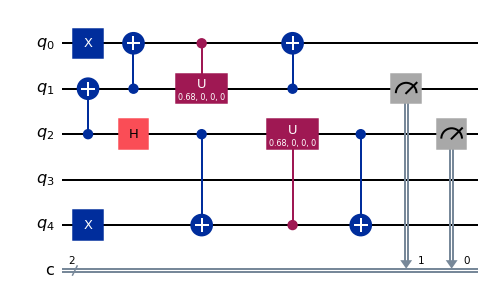

In [10]:
circuits['ZZ_XX']['00'][1].draw(output='mpl')

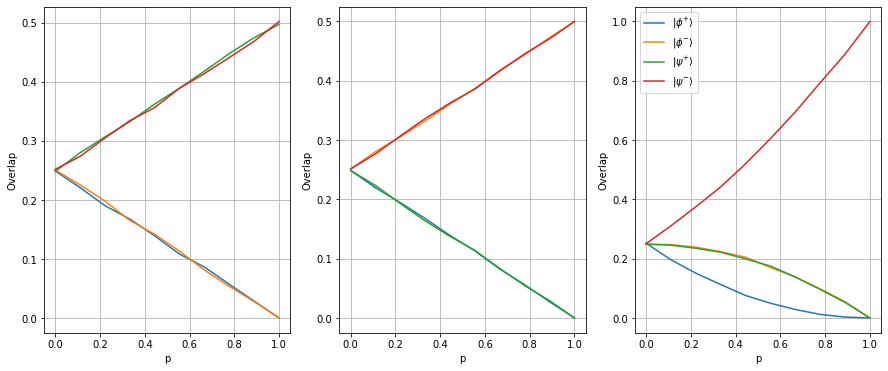

In [11]:
# Execute the circuits on the local simulator
jobs_sim = {}
for pump in pumps:
    jobs_sim[pump] = {}
    for ic in ic_state_labels:
        jobs_sim[pump][ic] = simulator.run(circuits[pump][ic], shots = SHOTS)

# Analyse the outcomes
overlaps_sim = {}
for pump in pumps:
    overlaps_sim[pump] = {}
    for ic in ic_state_labels:
        overlaps_sim[pump][ic] = [0.0]*len(p_values)
    for i in range(len(p_values)):
        for ic in ic_state_labels:
            counts = jobs_sim[pump][ic].result().get_counts(i)
            for outcome in counts:
                overlaps_sim[pump][outcome][i] += counts[outcome]/(4.0 * float(SHOTS))

# Plot the results
fig_idx = 131
plt.figure(figsize=(15,6))
bell_labels = {'00': r"$| \phi^{+} \rangle$", '01': r"$| \phi^{-} \rangle$", '10': r"$| \psi^{+} \rangle$", '11': r"$| \psi^{-} \rangle$"}
for pump in pumps:
    plt.subplot(fig_idx)
    for outcome in overlaps_sim[pump]:
        plt.plot(p_values, overlaps_sim[pump][outcome], label = bell_labels[outcome])
    plt.xlabel('p')
    plt.ylabel('Overlap')
    fig_idx += 1
    plt.grid()
plt.legend()

### Tehtävä 4

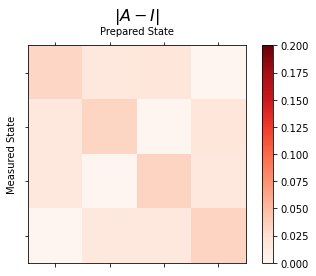

In [12]:
exp = LocalReadoutError(system, backend=backend)
exp.analysis.set_options(plot=True)
res = exp.run(shots=SHOTS)
mitigator = res.analysis_results(0).value
res.figure(0)

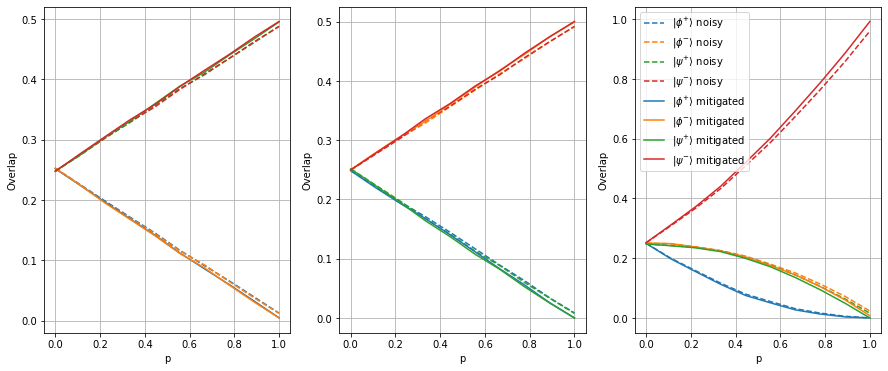

In [13]:
# Execute the circuits on the local simulator
jobs_sim = {}
for pump in pumps:
    jobs_sim[pump] = {}
    for ic in ic_state_labels:
        jobs_sim[pump][ic] = backend.run(circuits[pump][ic], shots = SHOTS)

overlaps = {}
overlaps_mit = {}

for pump in pumps:
    overlaps[pump] = {}
    overlaps_mit[pump] = {}
    for ic in ic_state_labels:
        overlaps[pump][ic] = [0.0]*len(p_values)
        overlaps_mit[pump][ic] = [0.0]*len(p_values)
    for i in range(len(p_values)):
        for ic in ic_state_labels:
            counts = jobs_sim[pump][ic].result().get_counts(i)
            unmitigated_probs = {label: count / SHOTS for label, count in counts.items()}
            mitigated_quasi_probs = mitigator.quasi_probabilities(unmitigated_probs)
            mitigated_probs = mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities()
            for outcome in unmitigated_probs:
                overlaps[pump][outcome][i] += unmitigated_probs[outcome]/4
            for outcome in mitigated_probs:
                overlaps_mit[pump][outcome[::-1]][i] += mitigated_probs[outcome]/4

# Plot the results
fig_idx = 131
plt.figure(figsize=(15,6))
colors = plt.rcParams['axes.prop_cycle'][0:4]
cycler_2 = plt.cycler(color=colors)
bell_labels = {'00': r"$| \phi^{+} \rangle$", '01': r"$| \phi^{-} \rangle$", '10': r"$| \psi^{+} \rangle$", '11': r"$| \psi^{-} \rangle$"}
for pump in pumps:
    plt.subplot(fig_idx)
    plt.gca().set_prop_cycle(cycler_2)
    for outcome in overlaps[pump]:
        plt.plot(p_values, overlaps[pump][outcome], label = f"{bell_labels[outcome]} noisy", ls='--')
    for outcome in overlaps_mit[pump]:
        plt.plot(p_values, overlaps_mit[pump][outcome], label = f"{bell_labels[outcome]} mitigated")
    plt.xlabel('p')
    plt.ylabel('Overlap')
    fig_idx += 1
    plt.grid()
plt.legend()

The difference between the readout error mitigated and non-mitigated results are not very big, because we're only measuring 2 qubits here. The more qubits we have the more errors we accumulate and the more readout error mitigation becomes important!